## Training an artificial neural network

In this notebook, we provide an example of how you can train an artificial neural network (ANN) for making predictions.
    
This is just for example purpose: the actual training of i-Melt ANNs is not done using this notebook. Several models are trained using Ray Tune, and i-Melt predictions are made by averaging predictions from the 10 best ANNs the search process provided.

## Library loading

First we load the necessary libraries.

We also check if we can use a GPU. 

In [1]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq et co. 2022-2024
# see embedded licence file
# imelt V2.2

import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility

import time, torch

# local imports
import imelt

from sklearn.metrics import root_mean_squared_error

#
# First we check if CUDA is available
# i-Melt provides a function to do that
#
device = imelt.get_default_device()
print(device)

CUDA AVAILABLE? 
Yes, setting device to cuda
cuda


## Loading data

To do that, we use the data loader with the default paths.

In [2]:
# custom data loader, automatically sent to device
ds = imelt.data_loader()
ds.print_data()

################################
#### Dataset specifications ####
################################

Number of unique compositions (viscosity): 790
Number of unique compositions in training (viscosity): 634
Dataset separations are 0.80 in train, 0.10 in valid, 0.10 in test

Number of unique compositions (entropy): 99
Number of unique compositions in training (entropy): 79
Dataset separations are 0.80 in train, 0.10 in valid, 0.10 in test

Number of unique compositions (refractive index): 610
Number of unique compositions in training (refractive index): 492
Dataset separations are 0.81 in train, 0.10 in valid, 0.10 in test

Number of unique compositions (glass density): 668
Number of unique compositions in training (glass density): 535
Dataset separations are 0.80 in train, 0.10 in valid, 0.10 in test

Number of unique compositions (glass elastic modulus): 1006
Number of unique compositions in training (glass elastic modulus): 808
Dataset separations are 0.80 in train, 0.10 in valid, 0.1

## Training 1 model

Here we use the reference architecture of i-Melt v1.2: 6 layers, 400 neurons per layer.

i-Melt v2 does not use ANN with fixed architectures.

We use GELU activation units, like in i-Melt v2.


In [3]:
nb_layers = 4
nb_neurons = 400
p_drop = 0.15

print("Network architecture is: {} layers, {} neurons/layers, dropout {}".format(nb_layers,nb_neurons,p_drop))

Network architecture is: 4 layers, 400 neurons/layers, dropout 0.15


We create a directory using `imelt.create_dir` to save the model and figures.

The model is created using the function `imelt.model`, and it is trained using the function `imelt.training`. This function implements early stopping: the best model on the validation sdataset is systematically saved in a folder indicated by save_name. Training is stopped when the patience is exceeded.

In [16]:
# Create directories if they do not exist
imelt.create_dir('./outputs/')

# name of the model, including output path
name = "./outputs/l"+str(nb_layers)+"_n"+str(nb_neurons)+"_p"+str(p_drop)+"_GELU_cpfree"+".pth"

# declaring model
neuralmodel = imelt.model(ds.x_visco_train.shape[1],
                          hidden_size=nb_neurons, # number of neurons per hidden layer
                          num_layers=nb_layers, # number of hidden layers
                          nb_channels_raman=ds.nb_channels_raman, # number of input channels for Raman spectra
                          activation_function = torch.nn.GELU(), # ANN activation function
                          p_drop=p_drop # dropout probability
                          )

# criterion for the optimization
criterion = torch.nn.MSELoss(reduction='mean')
criterion.to(device) # sending criterion on device


neuralmodel.output_bias_init() # we initialize the output bias
neuralmodel = neuralmodel.float() # we make sure we deal with float32 torch numbers
neuralmodel.to(device) # send the neural net on device

Directory  ./outputs/  already exists


model(
  (activation_function): GELU(approximate='none')
  (dropout): Dropout(p=0.15, inplace=False)
  (linears): ModuleList(
    (0): Linear(in_features=39, out_features=400, bias=True)
    (1-3): 3 x Linear(in_features=400, out_features=400, bias=True)
  )
  (out_thermo): Linear(in_features=400, out_features=34, bias=True)
  (out_raman): Linear(in_features=400, out_features=850, bias=True)
)

### Training !

We use the ADAM optimizer with a 0.0003 learning rate. Patience is set to 250 epochs (training will stop if the validation metric stops improving for 250 consecutive epochs).

In [17]:


#
# TRAINING
#
time1 = time.time()
optimizer = torch.optim.Adam(neuralmodel.parameters(), lr = 0.0002) # optimizer
neuralmodel, record_train_loss, record_valid_loss = imelt.training(neuralmodel, # model
                                                                   ds, # dataset
                                                                   criterion, # criterion for training (RMSE here)
                                                                   optimizer, # optimizer: ADAM
                                                                   save_switch=True, # do we save the best models?
                                                                   save_name=name, # where do we save them?
                                                                   train_patience=250, # how many epochs we wait until early stopping?
                                                                   min_delta=0.05, # how sensitive should we be to consider the validation metric has improved?
                                                                   verbose=True # do you want text?
                                                                   )

time2 = time.time()
print("It took {:.1f} seconds".format(time2-time1))
print(name)


TRAIN -- Raman: 82.818, d: 215.932, S: 18.013, RI: 342.223, V: 609.517, Cp: 2.005, Em: 24.308, CTE: 3.663, Ab: 3.039, Tl: 47.203
VALID -- Raman: 80.580, d: 219.776, S: 28.345, RI: 329.520, V: 309.501, Cp: 1.665, Em: 27.024, CTE: 2.369, Ab: 1.163, Tl: 46.638

Epoch 0 => loss train 3586.29, valid 3301.83; reg A: 0.000000
Epoch 20 => loss train 899.23, valid 938.15; reg A: 0.000000
Epoch 40 => loss train 579.40, valid 625.47; reg A: 0.000000
Epoch 60 => loss train 425.23, valid 527.45; reg A: 0.000000
Epoch 80 => loss train 336.25, valid 443.47; reg A: 0.000000

TRAIN -- Raman: 32.601, d: 7.711, S: 15.385, RI: 26.368, V: 22.189, Cp: 2.364, Em: 1.950, CTE: 2.640, Ab: 2.186, Tl: 22.621
VALID -- Raman: 30.329, d: 4.926, S: 24.139, RI: 16.506, V: 41.005, Cp: 0.127, Em: 2.981, CTE: 1.487, Ab: 0.751, Tl: 24.652

Epoch 100 => loss train 272.33, valid 384.47; reg A: 0.000000
Epoch 120 => loss train 223.64, valid 318.85; reg A: 0.000000
Epoch 140 => loss train 194.45, valid 280.49; reg A: 0.00000

### Plotting the losses on the training and validation datasets

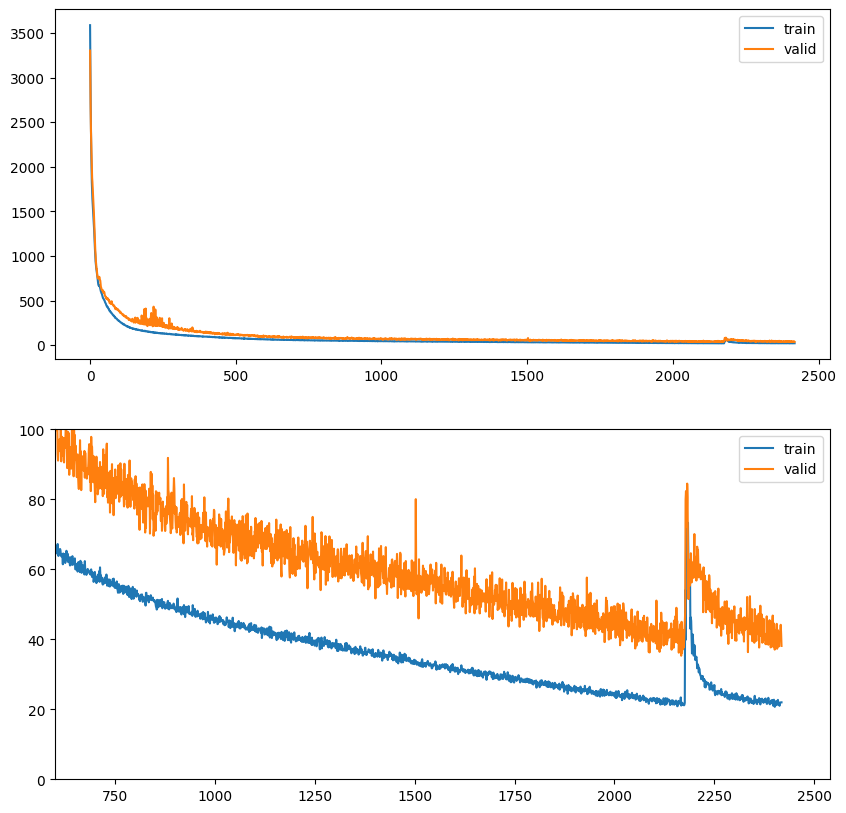

In [18]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(record_train_loss,label="train")
plt.plot(record_valid_loss,label="valid")
plt.legend()
# with zoom after 600 epochs
plt.subplot(2,1,2)
plt.plot(record_train_loss,label="train")
plt.plot(record_valid_loss,label="valid")
plt.xlim(600,)
plt.ylim(0,100)
plt.legend()
plt.savefig("./outputs/loss.pdf")

Training is not necessarily ideal here. It probably could be improved a bit. And it also depends on the initialisation, so sometimes one network will not converge to good results but another with the same architecture will... In any cases, this is a simple example of training. Many post training analysis can be performed, but this is out of the scope of this notebook that just aims at showing how you can train an ANN in i-Melt!